<a href="https://colab.research.google.com/github/crispitagorico/Neural-SPDEs/blob/main/data/data_generation_kdv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center> <h1>Data generator for the Korteweg–De Vries (KdV) equation</h1> </center>

***

In [1]:
!git clone "https://github.com/crispitagorico/Neural-SPDEs.git"

Cloning into 'Neural-SPDEs'...
remote: Enumerating objects: 497, done.
remote: Counting objects: 100% (497/497), done.
remote: Compressing objects: 100% (356/356), done.
remote: Total 497 (delta 288), reused 302 (delta 128), pack-reused 0
Receiving objects: 100% (497/497), 2.61 MiB | 2.82 MiB/s, done.
Resolving deltas: 100% (288/288), done.


In [2]:
%cd Neural-SPDEs/data

/content/Neural-SPDEs/data


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"

In [ ]:
%run Noise.ipynb
%run general_solver.ipynb
%run SPDE_Data_Generator.ipynb

# Dataset $\xi\to u$

We sample multiple paths $\xi^1, \ldots, \xi^n$ from a Q-Wiener process in one dimension, and then solve the
SPDE. The initial condition $u_0$ is kept fixed across the $n$ samples, and $u_0(x)=x(1-x)$. 

In [31]:
n = 1200 # number of solutions
Nx, Nt = 2**7, 10**3  # number of observations in space and time
dx, dt = 1./Nx, 1./Nt  # space-time discretization
a, b, s, t = 0, 1, 0, 1 # space-time boundaries

initial condition

In [32]:
u0 = np.array([[x*(1-x) for x in np.linspace(a,b,Nx+1)[:-1]] for _ in range(n)]) # initial condition

stochastic forcing

In [33]:
r = 4 # Creates r/2 spatially smooth noise
corr = lambda x, j, a : smooth_corr(x, j, a, r + 1.001)
W_smooth = Noise().WN_space_time_many(s, t, dt, a, b, dx, n, correlation = corr)

solve

In [34]:
L_kdv = [0,0,1e-3,-0.1,0]
mu_kdv = lambda x: 0 
sigma_kdv = lambda x: 1

KdV, _, _ = general_1d_solver(L_kdv, u0, W_smooth[:,:,:-1], mu = mu_kdv, sigma = sigma_kdv, Burgers= -6)

100%|██████████| 1000/1000 [00:57<00:00, 17.42it/s]


In [35]:
W = W_smooth.transpose(0,2,1)
soln = KdV.transpose(0,2,1)

In [36]:
O_X, O_T = np.linspace(0,1,W.shape[-2]), np.linspace(0,1,W.shape[-1])

In [ ]:
# scipy.io.savemat('../../drive/MyDrive/data_kdv/kdv_xi_{}.mat'.format(n), mdict={'X':O_X, 'T':O_T, 'W': W, 'sol': soln})

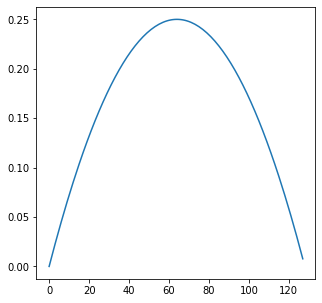

In [11]:
fig, ax = plt.subplots(figsize=(5,5))

def animate(t):
    plt.cla()
    plt.plot(soln[0,...,10*t])

matplotlib.animation.FuncAnimation(fig, animate, frames=100)

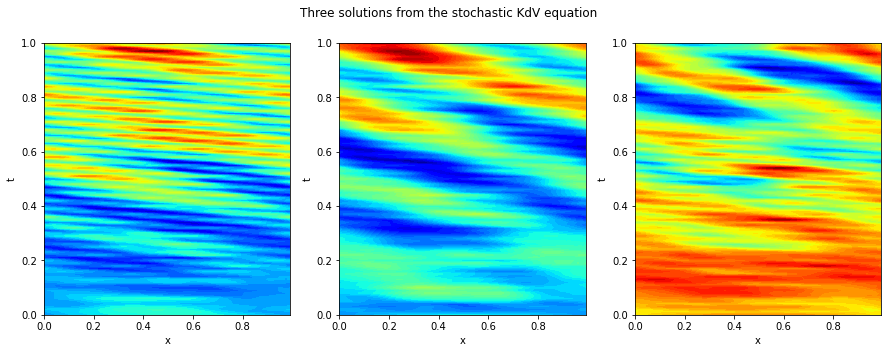

In [37]:
x_m, t_m = np.meshgrid(O_T[::10], O_X[:-1])

fig, ax = plt.subplots(1,3,figsize=(15,5))

for i in range(3):
  ax[i].contourf(t_m, x_m, soln[i,:,::10], 50, cmap=plt.cm.jet)
  ax[i].set_xlabel('x')
  ax[i].set_ylabel('t')
plt.suptitle(r'Three solutions from the stochastic KdV equation')
plt.show()

# Dataset $(u_0,\xi)\to u$

We sample multiple paths $\xi^1, \ldots, \xi^n$ from a Q-Wiener process in one dimension. We sample the initial condition $u_0^1, \ldots, u_0^n$ and then solve the
SPDE for each $(u_0^i,\xi^i)$.

In [38]:
n = 1200 # number of solutions
Nx, Nt = 2**7, 10**3  # number of observations in space and time
dx, dt = 1./Nx, 1./Nt  # space-time discretization
a, b, s, t = 0, 1, 0, 1 # space-time boundaries

In [44]:
u0 = np.array([[x*(1-x) for x in np.linspace(a,b,Nx+1)[:-1]] for _ in range(n)]) # initial condition

X_ = np.linspace(-0.5,0.5,Nx+1)
ic_ = Noise().initial(n, X_, scaling = 1, Dirichlet = True)[...,:-1] # one cycle

u0 = (ic_-ic_[:,0,None]) + u0

In [45]:
L_kdv = [0,0,1e-3,-0.1,0]
mu_kdv = lambda x: 0 
sigma_kdv = lambda x: 1

KdV_u0, _, _ = general_1d_solver(L_kdv, u0, W_smooth[:,:,:-1], mu = mu_kdv, sigma = sigma_kdv, Burgers= -6)

100%|██████████| 1000/1000 [00:59<00:00, 16.94it/s]


In [46]:
W = W.transpose(0,2,1)
soln = KdV_u0.transpose(0,2,1)

In [ ]:
# scipy.io.savemat('../../drive/MyDrive/data_kdv/kdv_xi_u0{}.mat'.format(n), mdict={'X':O_X, 'T':O_T, 'W': W, 'sol': soln})

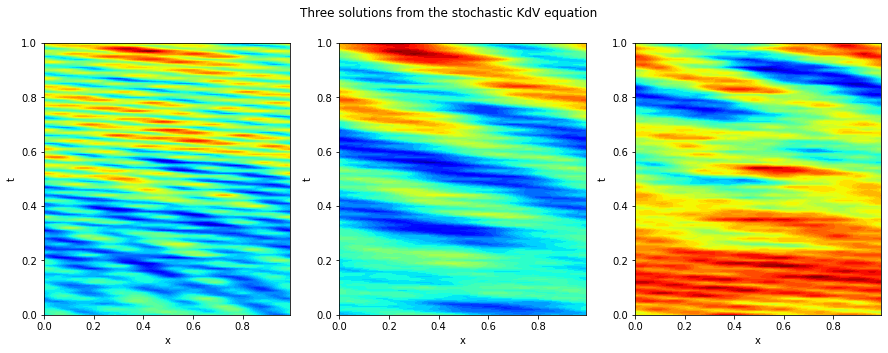

In [47]:
x_m, t_m = np.meshgrid(O_T[::10], O_X[:-1])

fig, ax = plt.subplots(1,3,figsize=(15,5))

for i in range(3):
  ax[i].contourf(t_m, x_m, soln[i,:,::10], 50, cmap=plt.cm.jet)
  ax[i].set_xlabel('x')
  ax[i].set_ylabel('t')
plt.suptitle(r'Three solutions from the stochastic KdV equation')
plt.show()

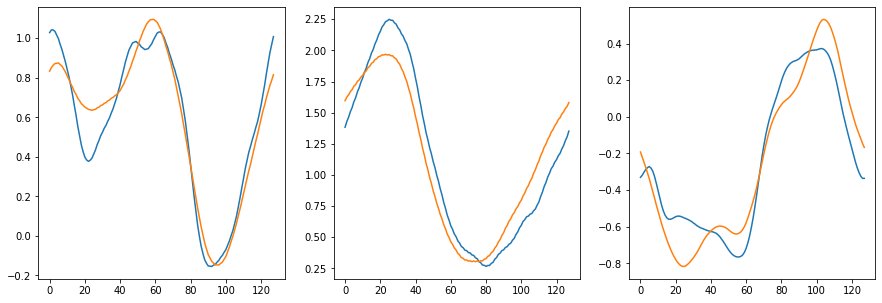

In [53]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i in range(3):  
  ax[i].plot(KdV_u0[i,-1,:])
  ax[i].plot(KdV[i,-1,:])
plt.show()